In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import readsav

#from create_spec import create_spec


import iris_lmsalpy.extract_irisL2data as extract_irisL2data
import iris_lmsalpy.fit_iris as fi

from matplotlib import animation, rc
from IPython.display import HTML

import sys
sys.path.append("../")
from iris2gauss import fit2gauss

In [2]:
path = '/Users/WilliamHenryAshfieldIV/dat/iris/'
filename = 'rast_data.sav'
fn = path+filename

In [3]:
ro = readsav(fn,verbose=False,python_dict=False)

In [4]:
data = ro.rast['data'][0]
wl = ro.rast['wl'][0]
err = ro.rast['err'][0]

In [5]:
jj = np.where((wl > 1402) & (wl < 1405))[0]
data = data[:,jj]
err = err[:,jj]
wl = wl[jj]

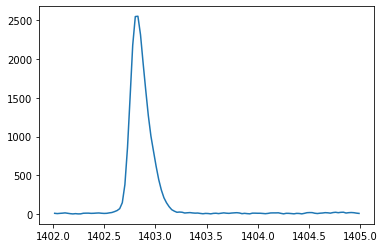

In [6]:
plt.plot(wl,data[1428])

In [7]:
data.shape

(2040, 118)

In [8]:
time = np.arange(1000,1600)
N = len(time)
print(N)

600


In [9]:
v_r = np.zeros(N)
v_b = np.zeros(N)
w_r = np.zeros(N)
w_b = np.zeros(N)

amp = np.zeros(N)

for i in range(0,N):
    
    t_i = time[i]
    
    dat = data[t_i,:]
    error = err[t_i,:]
        
    res = fit2gauss(wl,dat,error,chi_thr=250.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
        #w_b[i] = a2g[2]*freq
        #w_r[i] = a2g[5]*freq

    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5
        #w_r[i] = a2g[2]*freq
        #w_b[i] = a2g[5]*freq

../iris2gauss.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ef1 = np.exp( -0.5*( (x-a[1])/a[2] )**2 )
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
../iris2gauss.py:93: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(m2)
../iris2gauss.py:35: RuntimeWarning: invalid value encountered in double_scalars
  s = mvec[3]/mvec[2]**(1.5) # the skewness
../iris2gauss.py:38: RuntimeWarning: invalid value encountered in sqrt
  dv = np.sqrt(mvec[2]/f/(1.0-f)) # estimate of separation  v_red - v_blue
../iris2gauss.py:43: RuntimeWarning: invalid value encountered in sqrt
  a0 = dx*mvec[0]/(np.sqrt(2*np.pi*mvec[2]))


(1420, 1430)

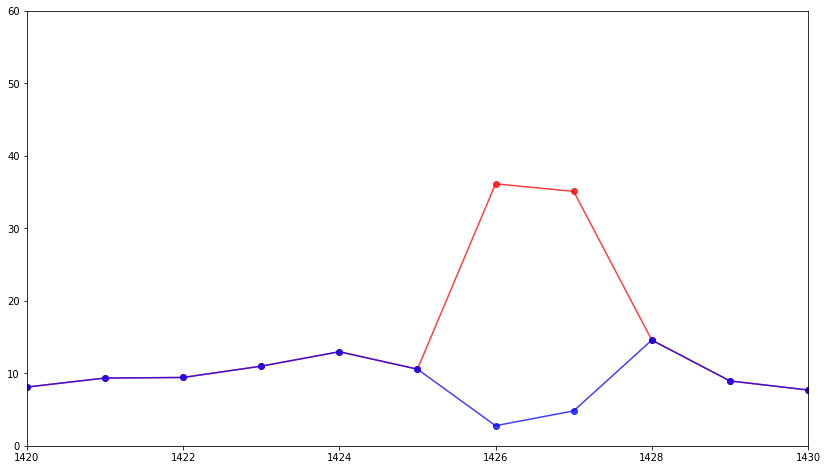

In [10]:
plt.figure(figsize=(14,8))
plt.plot(time,v_r,'r',alpha=0.75,marker='o')
plt.plot(time,v_b,'b',alpha=0.75,marker='o')
plt.ylim(0,60)
plt.xlim(1420,1430)

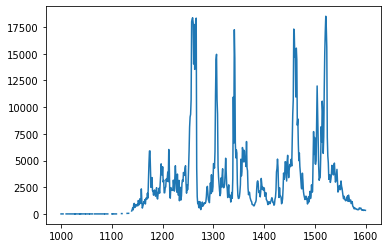

In [11]:
plt.plot(time,amp)
#plt.xlim(1400,1500)

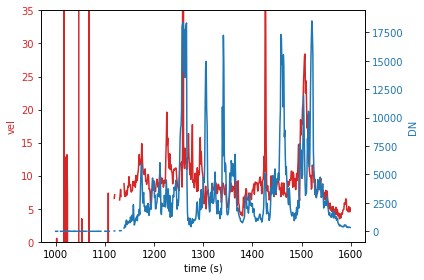

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('vel', color=color)
ax1.plot(time,v_r, color=color)
ax1.tick_params(axis='y', labelcolor=color)

#ax1.set_xlim(1400,1550)
ax1.set_ylim(0,35)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('DN', color=color)  # we already handled the x-label with ax1
ax2.plot(time,amp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [20]:
tt = np.arange(1420,1435)

array([10.98704406, 12.97850264, 10.57275896, 36.1407249 , 35.10165801,
       14.58079792,  8.95163188])

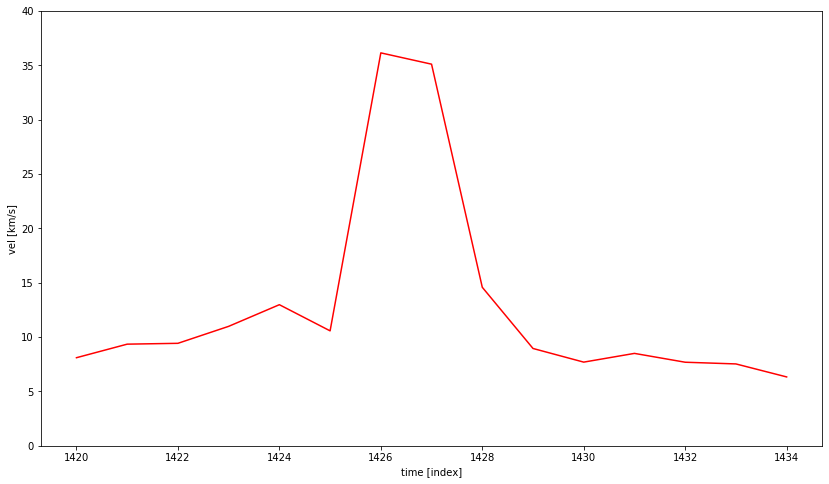

In [24]:
plt.figure(figsize=(14,8))
#plt.plot(tt,v_r[1420:1435], color='red')
plt.plot(tt,v_r[420:435], color='red')

plt.ylim(0,40)
plt.ylabel('vel [km/s]')
plt.xlabel('time [index]')
v_r[423:430]

Text(0.5, 0, 'time [s]')

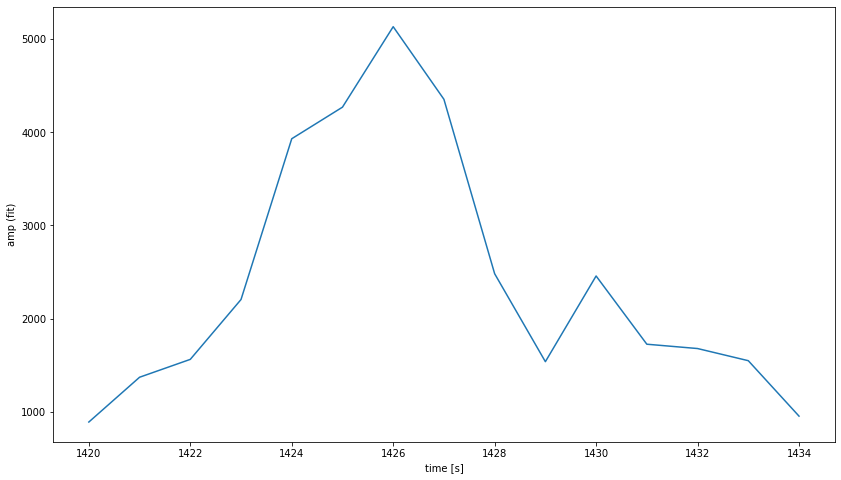

In [26]:
plt.figure(figsize=(14,8))
plt.plot(tt,amp[420:435])
plt.ylabel('amp (fit)')
plt.xlabel('time [s]')

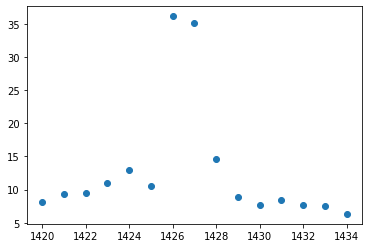

In [28]:
plt.plot(tt,v_r[420:435],'o')

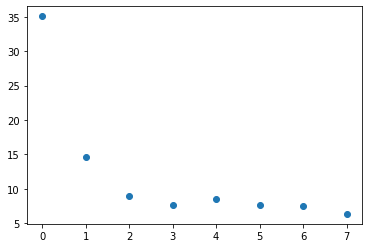

In [47]:
ttt = tt[7:]-tt[7]
vr = v_r[427:435]
plt.plot(ttt,vr, 'o')

In [48]:
from scipy.optimize import curve_fit
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [49]:
ttt *=5 # convert index to seconds
a0= [35,15]
popt, pcov = curve_fit(u0_fit, ttt, vr,p0=a0)

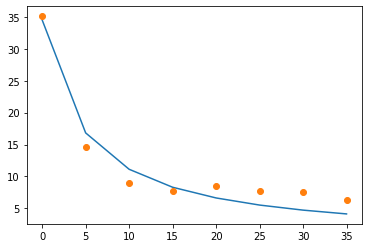

In [50]:
plt.plot(ttt,u0_fit(ttt,*popt))
plt.plot(ttt,vr,'o')

In [51]:
H = 0.6*popt[0]*popt[1]
print(H)

98.45760535070002


In [52]:
popt[1]

4.754091395446842